In [1]:
import numpyro
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import jax.numpy as jnp
import jax as jax
from jax import jit


gpu


In [5]:
name = 'sars'

if name=='flu2009':
    data=np.array([1,1,0,2,5,3,3,3,6,2,5,9,13,12,13,11,12,6,6,6,3,1,0,2,0,0,0,0,2,0,2,0]) # flu 2009
    g=np.array([0.000,0.233,0.359,0.198,0.103,0.053,0.027,0.014,0.007,0.003,0.002,0.001]) # flu 2009 1918
    T=g.shape[0]
if name=='flu1918':
    g=np.array([0.000,0.233,0.359,0.198,0.103,0.053,0.027,0.014,0.007,0.003,0.002,0.001]) # flu 2009 1918
    data=np.array([5,1,6,15,2,3,8,7,2,15,4,17,4,10,31,11,13,36,13,33,17,15,32,27,70,58,32,69,54,80,405,192,243,204,280,229,304,265,196,372,158,222,141,172,553,148,95,144,85,143,87,73,70,62,116,44,38,60,45,60,27,51,34,22,16,11,18,11,10,8,13,3,3,6,6,13,5,6,6,5,5,1,2,2,3,8,4,1,2,3,1,0]) # flu1918
    T=g.shape[0]
if name=='measles':
    g=np.array([0.00000,0.00000,0.00000,0.00000,0.00006,0.00052,0.00249,0.00792,0.01866,0.03508,0.05530,0.07574,0.09248,0.10263,0.10507,0.10042,0.09042,0.07730,0.06313,0.04951,0.03745,0.02742,0.01949,0.01350,0.00912,0.00603,0.00390,0.00248,0.00155,0.00095,0.00058,0.00034,0.00020,0.00012,0.00007,0.00004,0.00002,0.00001]) # measles
    data=np.array([1,0,1,0,0,0,0,0,2,1,0,0,2,1,1,0,2,0,1,1,1,3,15,12,7,5,5,3,5,3,6,12,18,14,16,13,12,4,6,0,3,0,2,3,3,1,2,0]) #measles
    T=g.shape[0]
if name=='smallpox':
    data=np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,1,3,0,0,0,0,0,0,0,0,2,1,0,3,8,8,16,6,20,19,7,4,4,1,0,0,1,3,2,4,0,0,1,1,0,1,1,1,0]) #small pox
    g=np.array([0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.002,0.005,0.009,0.014,0.021,0.029,0.038,0.046,0.054,0.060,0.065,0.067,0.067,0.066,0.063,0.058,0.053,0.048,0.042,0.036,0.031,0.026,0.021,0.017,0.014,0.011,0.009,0.007,0.005,0.004,0.003,0.002,0.002,0.001,0.001,0.001,0.001]) # smallpox
    T=g.shape[0]# pad data for seeding
if name=='sars':
    data=np.array([1,0,0,1,0,0,2,0,2,2,1,1,1,0,0,0,4,1,2,4,13,23,35,26,12,17,19,17,28,23,27,27,11,21,21,25,31,103,96,69,58,48,33,25,43,37,30,29,28,34,34,32,24,17,16,23,18,15,11,19,16,9,17,14,6,4,8,9,11,11,11,6,13,3,8,2,4,4,6,4,5,4,8,2,3,2,5,3,3,4,3,1,2,0,1,3,3,1,1,1,1,1,1,1,0,2,0])
    g=np.array([0.000,0.001,0.012,0.043,0.078,0.104,0.117,0.116,0.108,0.094,0.078,0.063,0.049,0.038,0.028,0.021,0.015,0.011,0.008,0.005,0.004,0.003,0.002,0.001,0.001])
    T=g.shape[0]# pad data for seeding
    
    addition = 10
data = np.append(np.repeat(0,addition),data)
# generate time points
x=np.linspace(1,data.size,data.size)
# serial interval and padding
g_raw=g
g=np.append(g,np.zeros(data.size-g.size))
g=g/np.sum(g)
# survival function 
G=np.append(1,np.abs(1-np.cumsum(g)))
# data size
n=data.size
# put on jax
y = jnp.array(data)

In [6]:
def model(y,Tg):

    def make_L(R,Tg):
        L = jnp.outer(R[::-1],Tg[::-1])
        L = jnp.triu(L,k=0)
        for i in range(1,n,1):
            L = jax.ops.index_update(L,jax.ops.index[:(i+1),i],L[:(i+1),i][::-1])
        return L 
    
    def make_H(R,Tg):
        H= jnp.ones((n,n))
        for i in range(n):
            H = jax.ops.index_update(H, jax.ops.index[:,i],Tg[i]*R)
        return H
    
    def case_reproudction_number(R,Tg):
        R_c = jnp.ones(n)
        for i in range(n):
            R_c = jax.ops.index_update(R_c,i,jnp.dot(R[i:],Tg[:n-i]))
        return R_c

    def compute_incidence(H,L):
        F = jnp.zeros((n,n))
        F = jax.ops.index_update(F,jax.ops.index[:,0],H[:,0])
        for i in range(n-1):
            F = jax.ops.index_update(F,jax.ops.index[(i+1):,i+1],H[(i+1):,i+1] + jnp.sum( F[(i+1):,:(i+1)] * L[:(n-i-1),(n-i-1):],axis=1))
        return jnp.diag(F)+1e-6
    # truncate
    def compute_incidence_fast(H,L):
        F = jnp.zeros((n,n))
        F = jax.ops.index_update(F,jax.ops.index[:,0],H[:,0])
        for i in range(T):
            F = jax.ops.index_update(F,jax.ops.index[(i+1):,i+1],H[(i+1):,i+1] + jnp.sum( F[(i+1):,:(i+1)] * L[:(n-i-1),(n-i-1):],axis=1))
        for i in range(T,n-1,1):
            F = jax.ops.index_update(F,jax.ops.index[(i+1):,i+1],H[(i+1):,i+1] + jnp.sum( F[(i+1):,(i+1-T):(i+1)] * L[:(n-i-1),(n-T):],axis=1))
        return jnp.diag(F)+1e-6

    # sample size
    n = y.size
    # overdispersion parameter
    phi = numpyro.sample("phi", dist.HalfNormal(2))
    # random walk variance
    sigma = numpyro.sample("sigma", dist.Exponential(50.0))
    # 1d random walk
    R_d = numpyro.sample(
        "R_d", dist.GaussianRandomWalk(scale=sigma, num_steps=n)
    )
    #exponential
    R = numpyro.deterministic('R',jnp.exp(R_d))
    # CMJ
    L = make_L(R,Tg)
    H = make_H(R,Tg)
    convert = numpyro.deterministic('convert',case_reproudction_number(R,Tg))
    incidence = numpyro.deterministic('incidence',compute_incidence_fast(H,L)) 
    #likelihood
    numpyro.sample('obs', dist.NegativeBinomial2(incidence[(addition):],phi), obs=y[(addition):])   

In [7]:
from jax import random
from numpyro.infer import MCMC, NUTS, BarkerMH
import numpyro.distributions as dist

import tensorflow_probability as tfp
def run(Dist):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=400, num_samples=400,progress_bar=True,num_chains=1,jit_model_args=True)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, y=y,Tg=jnp.array(Dist))
    post1 = mcmc.get_samples()
    return mcmc,post1

m1, post1 = run(g) #bellman--harris
m2, post2 = run(G[:n]) # point process


sample: 100%|██████████| 800/800 [05:24<00:00,  3.09it/s, 31 steps of size 1.52e-01. acc. prob=0.88] 


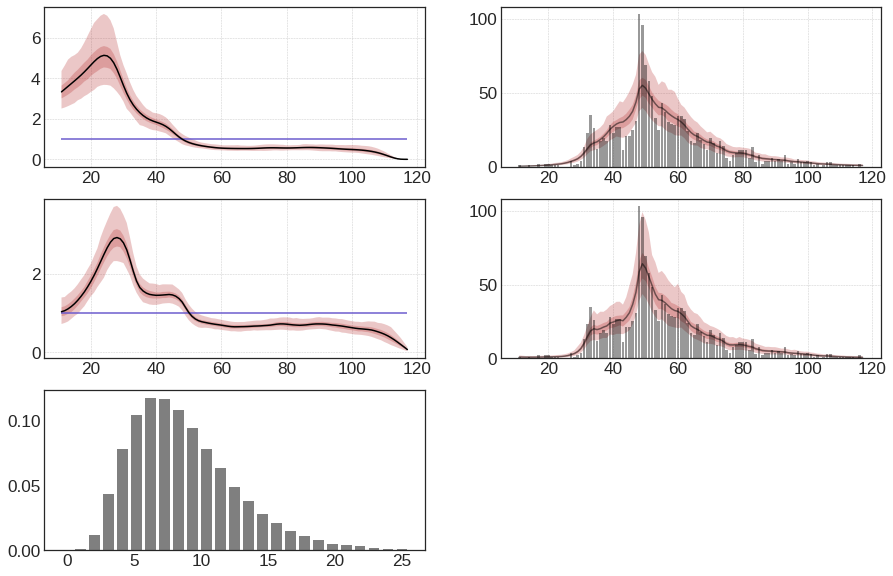

In [8]:
import matplotlib.style
import matplotlib as mpl
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
mpl.style.use('seaborn-white')
env = 'firebrick'
line = 'black'
fig, ((ax1, ax2),(ax4, ax5),(ax6,ax7)) = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

ax1.plot(x[addition:],np.mean(post1['convert'],0)[addition:],color=line)
ax1.fill_between(x[addition:], np.quantile(post1['convert'],axis=0,q=0.025)[addition:], np.quantile(post1['convert'],axis=0,q=0.975)[addition:], facecolor=env, alpha=0.25,
                label='1 sigma range')
ax1.fill_between(x[addition:], np.quantile(post1['convert'],axis=0,q=0.25)[addition:], np.quantile(post1['convert'],axis=0,q=0.75)[addition:], facecolor=env, alpha=0.25,
                label='1 sigma range')
ax1.hlines(1,np.min(x[addition:]),np.max(x[addition:]),color='slateblue')
#ax1.set_title('$R(t)$')
ax1.grid(linestyle='--', linewidth=0.5)

ax2.plot(x[(addition):],(np.mean(post1['incidence'],0)[addition:]),alpha=0.5,color=line)
ax2.fill_between(x[addition:], np.quantile(post1['incidence'],axis=0,q=0.025)[addition:], np.quantile(post1['incidence'],axis=0,q=0.975)[addition:], facecolor=env, alpha=0.25,
                 label='1 sigma range')
ax2.fill_between(x[addition:], np.quantile(post1['incidence'],axis=0,q=0.25)[addition:], np.quantile(post1['incidence'],axis=0,q=0.75)[addition:], facecolor=env, alpha=0.25,
                 label='1 sigma range')
ax2.bar(x[(addition):],(y[addition:]),alpha=0.4,color='black')
#ax2.set_title('Incidence')
ax2.grid(linestyle='--', linewidth=0.5)


ax4.plot(x[addition:],np.mean(post2['convert'],0)[addition:],color=line)
ax4.fill_between(x[addition:], np.quantile(post2['convert'],axis=0,q=0.025)[addition:], np.quantile(post2['convert'],axis=0,q=0.975)[addition:], facecolor=env, alpha=0.25,
                label='1 sigma range')
ax4.fill_between(x[addition:], np.quantile(post2['convert'],axis=0,q=0.25)[addition:], np.quantile(post2['convert'],axis=0,q=0.75)[addition:], facecolor=env, alpha=0.25,
                label='1 sigma range')
ax4.hlines(1,np.min(x[addition:]),np.max(x[addition:]),color='slateblue')
#ax4.set_title('$\int \\rho(u)(1-G(u))$')
ax4.grid(linestyle='--', linewidth=0.5)


ax5.plot(x[(addition):],(np.mean(post2['incidence'],0)[addition:]),alpha=0.5,color=line)
ax5.fill_between(x[addition:], np.quantile(post2['incidence'],axis=0,q=0.025)[addition:], np.quantile(post2['incidence'],axis=0,q=0.975)[addition:], facecolor=env, alpha=0.25,
                 label='1 sigma range')
ax5.fill_between(x[addition:], np.quantile(post2['incidence'],axis=0,q=0.25)[addition:], np.quantile(post2['incidence'],axis=0,q=0.75)[addition:], facecolor=env, alpha=0.25,
                 label='1 sigma range')
ax5.bar(x[(addition):],(y[addition:]),alpha=0.4,color='black')
#ax5.set_title('Incidence')
ax5.grid(linestyle='--', linewidth=0.5)

ax6.bar(np.linspace(0,g_raw.size,g_raw.size),g_raw,alpha=0.5,color='black')
#ax6.set_title('Generation time $g(t)$')


ax7.axis('off')


plt.savefig('/home/DIDE/sjbhatt/'+name+'.pdf'  )


In [9]:
import arviz as az
az.compare({'model_1': m1,
            'model_2': m2},method='stacking' ,scale='deviance',ic='waic')


/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior var

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,563.842861,11.527122,0.000000,1.000000e+00,24.375450,0.000000,True,deviance
model_1,1,572.085844,9.772241,8.242983,7.105427e-15,26.232126,4.475985,True,deviance
